# Project 3: Web APIs & NLP
# Notebook II - EDA, Modeling

Author: Julie Vovchenko

---

## Table of Content:
- [Preliminary Exploratory Data Analisys (EDA)](#Preliminary-Exploratory-Data-Analisys-(EDA))
-  [Data Cleaning](#Data-Cleaning)  
-  [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA)) 
-  [Model Preparation (Preprocessing)](#Model-Preparation-(Preprocessing)) 
-  [Modeling](#Modeling)
    -  [Baseline Model](#Baseline-Model)
    -  [Count Vectorizer & Logistic Regression](#Count-Vectorizer-&-Logistic-Regression)   
    -  [Tfidf Vectorizer & Logistic Regression](#Tfidf-Vectorizer-&-Logistic-Regression)
    -  [Count Vectorizer & Multinomial Naive Bayes](#Count-Vectorizer-&-Multinomial-Naive-Bayes)  
    -  [Tfidf Vectorizer & Gaussian Naive Bayes](#Tfidf-Vectorizer-&-Gaussian-Naive-Bayes) 
-  [Model Selection](#Model-Selection)     
-  [Confusion Matrix](#Confusion-Matrix)     
-  [ROC AUC Curve](#ROC-AUC-Curve)     
-  [Coefficients](#Coefficients)  
-  [Conclusion and Recommendations](#Conclusion-and-Recommendations) 
-  [Next Steps](#Next-Steps) 
-  [References](#References)

## Dataset

- [Scrapped Dataframe of Both Subreddits](../data/both_scraped_subreddits.csv)

## Preliminary Exploratory Data Analisys (EDA)

For preliminary EDA we would be working with scraped raw data that we saved in both_scraped_subreddits.csv file and delete columns of data that wont be using.

In [39]:
# Importing Libraries: 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import regex as re
import nltk
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup 

# Import sklearn feature_extraction and metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin # this allows us to create a custom transformer

In [2]:
# Reading the file with scrapped data and assigning it to 'df' dataframe
df = pd.read_csv('../data/both_scraped_subreddits.csv')
# Checking the first 5 rows of the dataframe
df.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Two month old sleeping 8-9 hours at a time.,My daughter is two months old today. Normally ...,Parenting,1577553731,shiteinmemooth,7,1,True,2019-12-28
1,Living room takeovers,Son spends all his waking hours watching YouTu...,Parenting,1577553829,Rach_InOz,11,1,True,2019-12-28
2,I freaking hate the baby stage.,[removed],Parenting,1577553878,HokieGirl07,1,1,True,2019-12-28
3,How To Set Your Christmas Budget Each Year,[removed],Parenting,1577554458,poochy30318,1,1,True,2019-12-28
4,"Arguing infront of child, is he gonna be fine??",Me and my partner argue alot (not my kids moth...,Parenting,1577555703,Difficult-Variety,20,1,True,2019-12-28


In [3]:
# Checking value counts and types of data in each column in dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 9 columns):
title           4994 non-null object
selftext        4954 non-null object
subreddit       4994 non-null object
created_utc     4994 non-null int64
author          4994 non-null object
num_comments    4994 non-null int64
score           4994 non-null int64
is_self         4994 non-null bool
timestamp       4994 non-null object
dtypes: bool(1), int64(3), object(5)
memory usage: 317.1+ KB


In [4]:
# Checking the size of the dataframe
df.shape

(4994, 9)

**Observation:**  
There are 4994 rows of data collected, which is sufficient enough for analysis. 

In [5]:
# Deciding to drop several columns of the dataframe that we have no value of
df.drop(['created_utc', 'score', 'is_self'], axis=1, inplace=True)

In [6]:
# Checking the dataframe with only columns that we need
df.head()

,title,selftext,subreddit,author,num_comments,timestamp
0,Two month old sleeping 8-9 hours at a time.,My daughter is two months old today. Normally ...,Parenting,shiteinmemooth,7,2019-12-28
1,Living room takeovers,Son spends all his waking hours watching YouTu...,Parenting,Rach_InOz,11,2019-12-28
2,I freaking hate the baby stage.,[removed],Parenting,HokieGirl07,1,2019-12-28
3,How To Set Your Christmas Budget Each Year,[removed],Parenting,poochy30318,1,2019-12-28
4,"Arguing infront of child, is he gonna be fine??",Me and my partner argue alot (not my kids moth...,Parenting,Difficult-Variety,20,2019-12-28


## Data Cleaning

Data cleaning will involve:  
1. Deleting rows with null values
2. converting the subreddit names to either 1 or 0. 
3. Cleaning the body of the texts in columns 'title' and 'selftext' by removing HTML artifacts and website links and lowering all the letters. 
4. Cleaning text from '\n' (newline) and '\r' (carriage return)
5. Concatenating both 'title' and 'selftext' in a new separate column 'title_text', because some posts miss on body of the text but have the title, and we don’t want to limit ourselves to only titles or selftexts.


In [7]:
# Finding count of nulls in each column
df.isnull().sum()

title            0
selftext        40
subreddit        0
author           0
num_comments     0
timestamp        0
dtype: int64

**Observation:**  
There are 40 rows with Null values in column selftext. We decided to remove them all together, since our dataset is quite large. 

In [8]:
# Removing rows with nulls in 'selftext' column
df.dropna(subset=['selftext'], inplace=True)

In [9]:
# Checking the count of nulls for the dataset again
df.isnull().sum()

title           0
selftext        0
subreddit       0
author          0
num_comments    0
timestamp       0
dtype: int64

In [10]:
# Checking the size of the dataset after the dropping rows with null values
df.shape

(4954, 6)

In [11]:
# Converting 'Parenting' and 'stepparents' into 1 and 0 
df['subreddit'] = df['subreddit'].map({'Parenting': 1, 'stepparents': 0})

In [12]:
# Viewing the result of the above mentioned conversion
df.head()

,title,selftext,subreddit,author,num_comments,timestamp
0,Two month old sleeping 8-9 hours at a time.,My daughter is two months old today. Normally ...,1,shiteinmemooth,7,2019-12-28
1,Living room takeovers,Son spends all his waking hours watching YouTu...,1,Rach_InOz,11,2019-12-28
2,I freaking hate the baby stage.,[removed],1,HokieGirl07,1,2019-12-28
3,How To Set Your Christmas Budget Each Year,[removed],1,poochy30318,1,2019-12-28
4,"Arguing infront of child, is he gonna be fine??",Me and my partner argue alot (not my kids moth...,1,Difficult-Variety,20,2019-12-28


In [13]:
# Creating a function that will clean data in any of the column of our dataset.
# Cleaning from HTML artifacts, website links, newlines, carriage returns,
# and also removing text '[removed]' for those rows where posts were removed,
# but reddit.com kept the comments for the removed post.
# Lowering all letters, to optimize work for Count and TDFIG Vectorizers 

def clean_column(column):
    # remove all HTML artifacts
    df[column] = [BeautifulSoup(text).get_text() for text in df[column]]
    # lower all the letters in column
    df[column] = df[column].str.lower()
    # removing '[removed]' from column, as the column was originally with no text
    df[column] = [post.replace('[removed]','') for post in df[column]]
    # remove '\n' from any text in column
    df[column] = [post.replace('\n','') for post in df[column]]
    # remove '\r' from any text in column
    df[column] = [post.replace('\r','') for post in df[column]]
    # removed all website links 
    df[column] = df[column].str.replace('http\S+|www.\S+', '', case=False)
    return 
      

# Running the function through columns 'title' and 'selftext'
clean_column('title')
clean_column('selftext')

/Users/juliev/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:357: UserWarning: "https://www.informative-talks.com/2019/07/to-make-stubborn-child-wise-then-adopt.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/juliev/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:357: UserWarning: "https://youtu.be/8Ip0ebe02WU" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/juliev/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:357: UserWarning: "https://www.google.com/amp/s/variety.com/2019/film/podcasts/why-queen-slim-star-jodie-turner-smith-isnt-sure-about-raising-a-f

In [14]:
# Putting all texts from both columns 'title' and 'selftext'
# together, for those cases where user left only title and no self_text
df['title_text'] = df['title'] + df['selftext']
df.head(3)

,title,selftext,subreddit,author,num_comments,timestamp,title_text
0,two month old sleeping 8-9 hours at a time.,my daughter is two months old today. normally ...,1,shiteinmemooth,7,2019-12-28,two month old sleeping 8-9 hours at a time.my ...
1,living room takeovers,son spends all his waking hours watching youtu...,1,Rach_InOz,11,2019-12-28,living room takeoversson spends all his waking...
2,i freaking hate the baby stage.,,1,HokieGirl07,1,2019-12-28,i freaking hate the baby stage.


## Exploratory Data Analysis (EDA)

1. Defining which day of the week is most active for each subreddit, when step/parents post the most, to find a pattern.  
2. Finding posts with most comments, so see what subjects interest parents the most.

In [15]:
# Checking what type objects are in 'timestamp' column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4954 entries, 0 to 4993
Data columns (total 7 columns):
title           4954 non-null object
selftext        4954 non-null object
subreddit       4954 non-null int64
author          4954 non-null object
num_comments    4954 non-null int64
timestamp       4954 non-null object
title_text      4954 non-null object
dtypes: int64(2), object(5)
memory usage: 309.6+ KB


In [16]:
df['timestamp'] = pd.to_datetime(df.timestamp) 
df['day'] = df['timestamp'].dt.dayofweek
df['day'].unique()

array([5, 6, 0, 1, 2, 3, 4])

In [17]:
df['weekday'] = df['day'].map({0: 'Monday', 
                               1: 'Tuesday',
                               2: 'Wednsday',
                               3: 'Thursday',
                               4: 'Friday',
                               5: 'Saturday',
                               6: 'Sunday'})

df['weekday'].unique()

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednsday', 'Thursday',
       'Friday'], dtype=object)

In [18]:
df['weekday'].value_counts()

Monday      849
Tuesday     824
Sunday      792
Saturday    677
Wednsday    640
Friday      637
Thursday    535
Name: weekday, dtype: int64

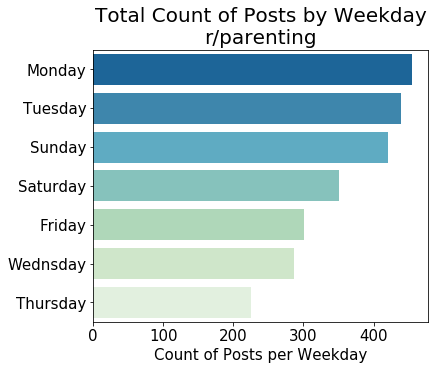

In [19]:
sub1 = df[df['subreddit'] == 1]['weekday'].value_counts().reset_index()

plt.figure(figsize=(6,5))
sns.barplot(data=sub1,
            y='index',
            x='weekday',
            palette="GnBu_r");

# Setting the title to size 35
plt.title ('Total Count of Posts by Weekday\nr/parenting', 
           size=20);
plt.ylabel('');
plt.xlabel('Count of Posts per Weekday', size = 15);
# Setting size of yticks and xticks to 20
plt.yticks(size = 15);
plt.xticks(size = 15);

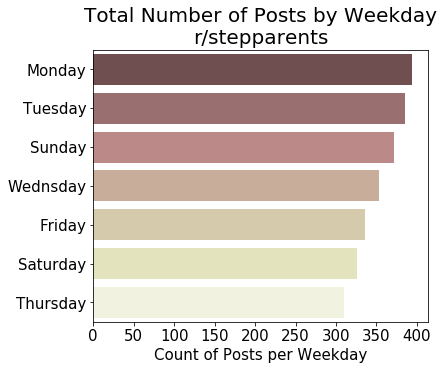

In [20]:
sub0 = df[df['subreddit'] == 0]['weekday'].value_counts().reset_index()

plt.figure(figsize=(6,5))
sns.barplot(data=sub0,
            y='index',
            x='weekday',
            palette="pink");

plt.ylabel('');
plt.xlabel('Count of Posts per Weekday', size = 15);
# Setting the title to size 35
plt.title ('Total Number of Posts by Weekday\nr/stepparents', 
           size=20);
# Setting size of yticks and xticks to 20
plt.yticks(size = 15);
plt.xticks(size = 15);

**Observation:**  
These graphs are telling us that Monday and Tuesday are the most active day of the week. We would assume that this happens because weekends are usually busy, dealing with household and children related errands and first two weeks of the work week parents want to express their problems or questions that they dealt with over the weekend.

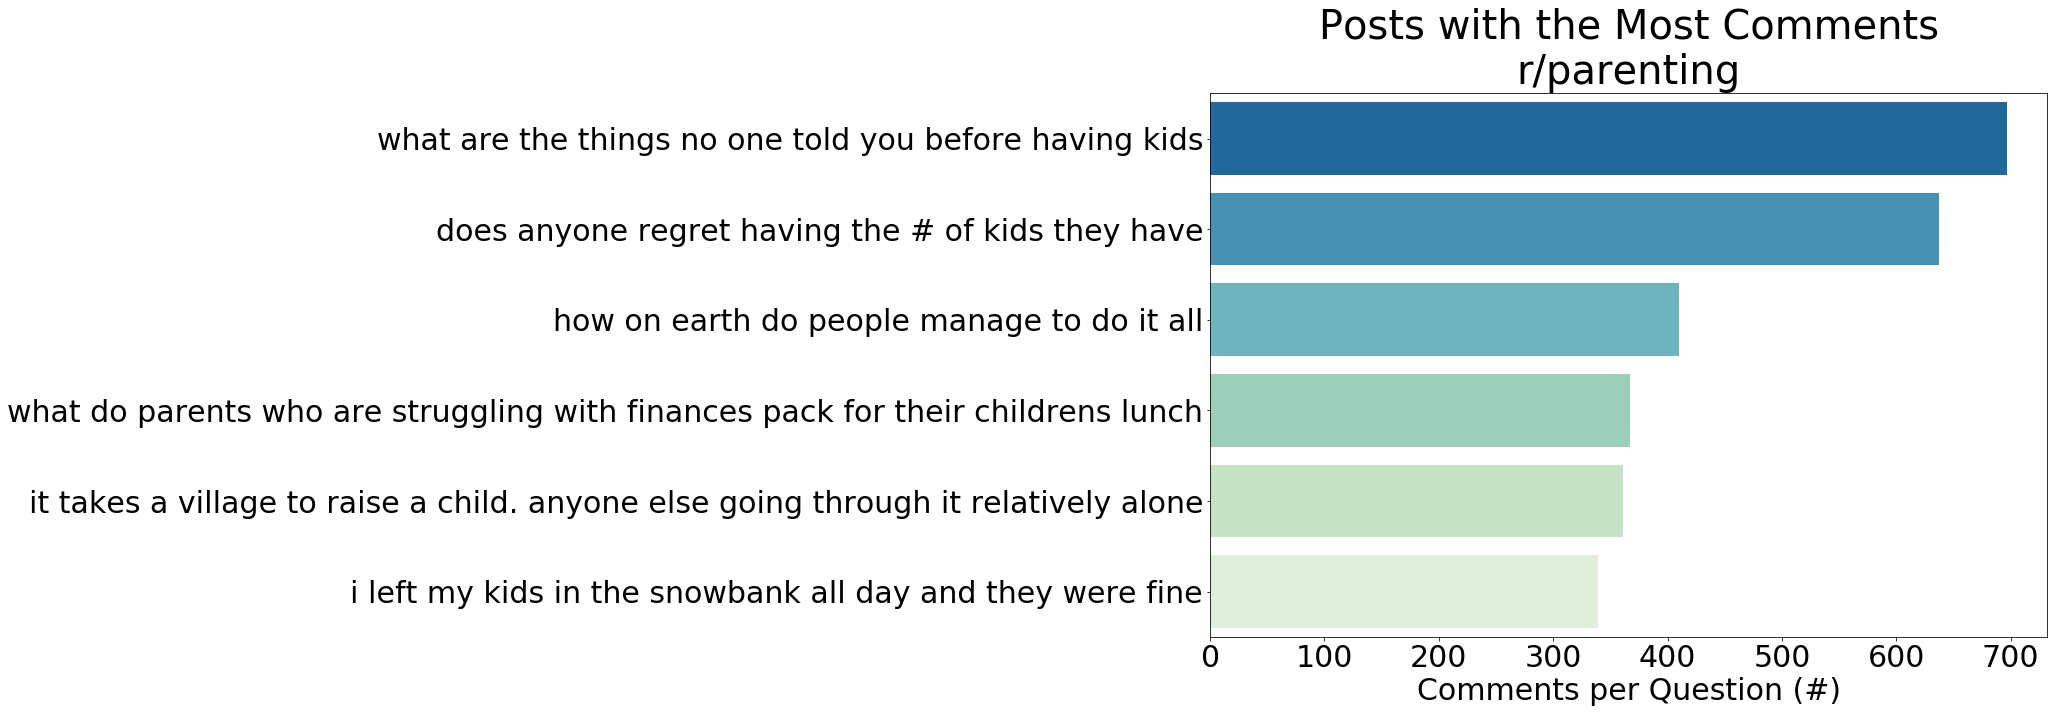

In [21]:
# Ploting the top 6 posts title with the most comments count, to see what parents
# tend to discuss. Viewing most hot subjects.
sub1_comments = df[(df['subreddit'] == 1) & (df['num_comments'] > 335)][['title', 'num_comments']].sort_values('num_comments', ascending=False)

# Cleaning titles from junk characters
sub1_comments['title'] = sub1_comments['title'].str.replace('“', '')
sub1_comments['title'] = sub1_comments['title'].str.replace('”', '')

# Shortening the title of the post to the first question mark
sub1_comments['short_title'] = sub1_comments['title'].str.split('?').str[0]

plt.figure(figsize=(15,10))
sns.barplot(data=sub1_comments,
            y='short_title', # showing titles
            x='num_comments', #number of columns
            palette="GnBu_r"); #chosing the color of the graph

# Setting the title to size 35
plt.title ('Posts with the Most Comments\nr/parenting', 
           size=40);

# Deleting ylabel
plt.ylabel('');
plt.xlabel('Comments per Question (#)', size = 30);
# Setting size of yticks and xticks to 20
plt.yticks(size = 30);
plt.xticks(size = 30);

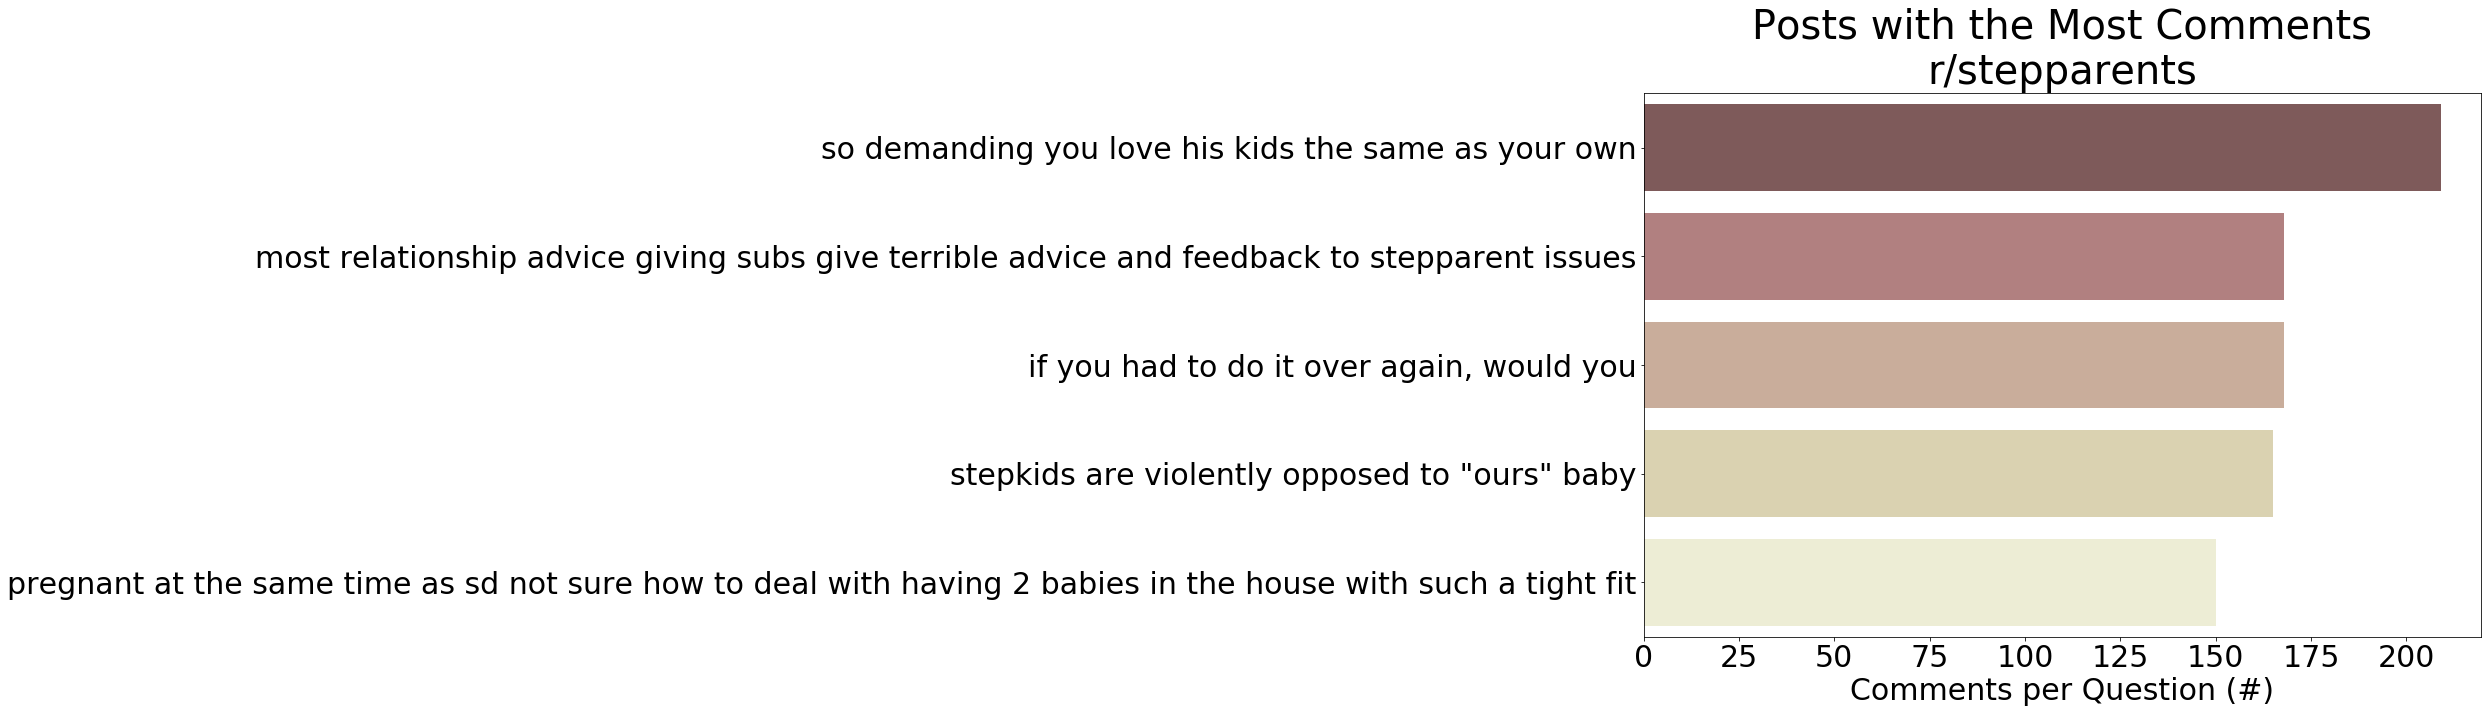

In [22]:
# Ploting the top 5 posts title with the most comments count, to see what parents
# tend to discuss. Viewing most hot subjects.
sub2_comments = df[(df['subreddit'] == 0) & (df['num_comments'] >147)][['title', 'num_comments']].sort_values('num_comments', ascending=False)
# Cleaning titles from junk characters
sub2_comments['title'] = sub2_comments['title'].str.replace('.', '')
sub2_comments['short_title'] = sub2_comments['title'].str.split('?').str[0]

plt.figure(figsize=(15,10))
sns.barplot(data=sub2_comments,
            y='short_title',
            x='num_comments',
            palette="pink");

# Setting the title to size 35
plt.title ('Posts with the Most Comments\nr/stepparents', 
           size=40);
plt.ylabel('');
plt.xlabel('Comments per Question (#)', size = 30);
# Setting size of yticks and xticks to 20
plt.yticks(size = 30);
plt.xticks(size = 30);

**Observation:**  
Most pressing issues that parents discuss in 'parenting' subreddit are 'what are the things that no one told you before having kids' and 'does anyone regret having # of kids they have' in 'parenting' subreddit.  
In the other hand members of 'stepparenting' group mostly discuss 'so demanding to love kids the same as your own' and 'if you had to do it over again, would you'. 

## Model Preparation (Preprocessing)

1. Determining most common 1-gram words in both subreddits and adding them to stopwords (for potentially using them in our models)
2. Identify 2-gram most popular word that might be included in our stopword-list
3. Pre-process our text, by using Lemmatizer. We will break each text into separate words, lemmatize these words and put them back together into a string of words.
4. Splitting our dataset into Train and Test parts.


In [23]:
# Function that finds top 20 words in the df
def top_20(subreddit, ngrams = (1,1), stopword_list = 'english'):
    # Finding top 20 words that show up in a subreddit
    # initializing the CountVectorizer to count each word
    cvec = CountVectorizer(ngram_range= ngrams,stop_words = stopword_list)
    # fitting given subreddit into CountVectorizer
    df_cv = cvec.fit(subreddit)

    # The CVEC function creates a sparse matrix. To dense brings it back to separate words
    df_cv = pd.DataFrame(cvec.transform(subreddit).todense(),columns=cvec.get_feature_names())
    # Getting the sum of counts for each word
    highest_cv = df_cv.sum(axis=0)
    # Sorting the all counted words in descending order and getting only top 20
    df_cvec = highest_cv.sort_values(ascending = False).head(20)
    # Putting the list of all words and their counts into one dataset
    df_words_sub = pd.DataFrame({'words':df_cvec.index, 'count':df_cvec.values})
    
    # Returning the new created dataframe of words and their counts
    return df_words_sub

In [24]:
# The list of all title_text for subreddit_1 ('Parenting')
subreddit1 = df[df['subreddit']==1]['title_text']
# Finding top 20 words for subreddit1
words1 = top_20(subreddit1)
# Adding a new column with a name of the subreddit we just got the top 20
words1['subreddit'] = 'Parenting'

# The list of all title_text for subreddit_2 ('stepparenting')
subreddit2 = df[df['subreddit']==0]['title_text']
# Finding top 20 words for subreddit1
words2 = top_20(subreddit2)
# Adding a new column with a name of the subreddit we just got the top 20
words2['subreddit'] = 'stepparenting'

# Concatenating both top 20 words from both subreddits into one dataset
df_words_both = pd.concat([words1, words2])
# Sorting the values in descending order
df_words_both = df_words_both.sort_values(by = 'count', ascending = False)

# Checking the work of top 10 words in both subreddits
df_words_both.head(10)

,words,count,subreddit
0,just,3670,stepparenting
1,bm,3091,stepparenting
2,like,2919,stepparenting
3,time,2764,stepparenting
4,kids,2562,stepparenting
0,just,2469,Parenting
5,don,2455,stepparenting
6,want,2097,stepparenting
7,sd,2052,stepparenting
1,like,2051,Parenting


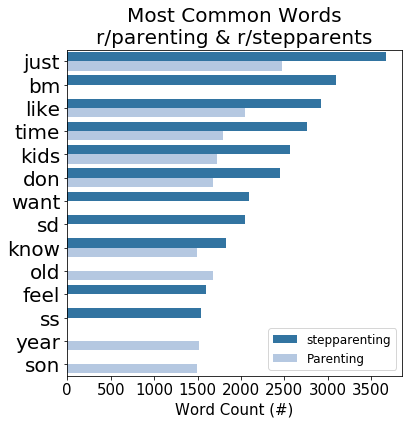

In [25]:
# Visualizing most common words for each subreddit together, since some of the words
# appear frequently in both subreddits
plt.figure(figsize=(6,6))
sns.barplot(data=df_words_both.head(20),
            y='words',
            x='count',
            hue = 'subreddit',
            palette="tab20");

# Setting the title to size 35
plt.title ('Most Common Words\nr/parenting & r/stepparents', 
           size=20);
plt.ylabel('');
plt.xlabel('Word Count (#)', size = 15);
# Setting size of yticks and xticks to 20
plt.yticks(size = 20);
plt.xticks(size = 15);
plt.legend(loc='lower right', fontsize='large', frameon=True);

**Observation:**  
Most common words that appear in both subreddits are: just, like, time, kids, don, know. Adding them to our stopword-list so model can use them to help optimize the accuracy.

In [26]:
# Creating the list of additional stop words that 
# Appeared in both subreddits
stopwords = nltk.corpus.stopwords.words('english')

# Our list of stop words that we want to include to 
# 'english' stopword list
newStopWords = ['just', 'like', 'time', 'kids', 'don', 'know',
               'year', 'school']

# Adding our list of special stop words to 'english' stopwords list
stopwords.extend(newStopWords)

**Note:**  
Further, by adding stop words into our stopword-list, we would like to explore top 20 2-gram words that appeared in each subreddit, by using our top_20 function.

In [27]:
# Finding top 20 2 gram words for subreddit1
words1_2gram = top_20(subreddit1, ngrams=(2,2), stopword_list=stopwords)
# Finding top 20 2 gram words for subreddit2
words2_2gram = top_20(subreddit2, ngrams=(2,2), stopword_list=stopwords)

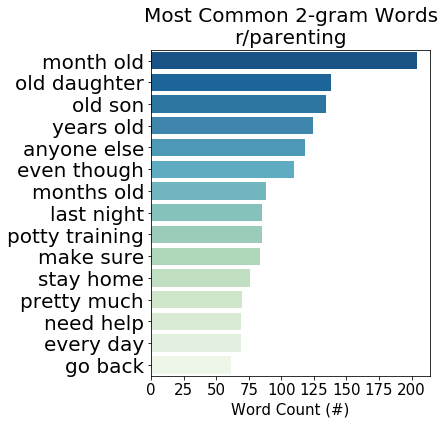

In [28]:
# Viewing the result of top 20 2-gram words in subbredit1
plt.figure(figsize=(5,6))
sns.barplot(data=words1_2gram.head(15),
            y='words',
            x='count',
            palette="GnBu_r");

# Setting the title to size 35
plt.title ('Most Common 2-gram Words\nr/parenting', 
           size=20);
plt.ylabel('');
plt.xlabel('Word Count (#)', size = 15);
# Setting size of yticks and xticks to 20
plt.yticks(size = 20);
plt.xticks(size = 15);

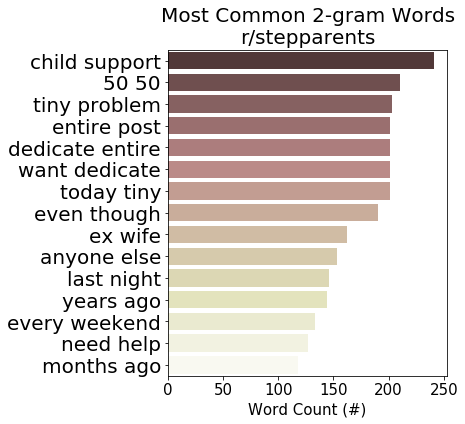

In [29]:
# Viewing the result of top 20 2-gram words in subbredit2
plt.figure(figsize=(5,6))
sns.barplot(data=words2_2gram.head(15),
            y='words',
            x='count',
            palette="pink");

# Setting the title to size 35
plt.title ('Most Common 2-gram Words\nr/stepparents', 
           size=20);
plt.ylabel('');
plt.xlabel('Word Count (#)', size = 15);
# Setting size of yticks and xticks to 20
plt.yticks(size = 20);
plt.xticks(size = 15);

**Observation:**  
Top 20 2-gram words list are very different for each subreddits, and we would like to stop collecting stop words because there are no repetitions and adding more stop words wont make any difference at this point.

In [30]:
# This function brakes sentences into words, then lemmatizes them
# and put it back into string of lists
def pre_process(string):
    
    lemmatizer = WordNetLemmatizer()
    # Empty list of lemmatized words
    lem_list = []
    # Split our string into strings
    strings = string.split()
    
    for word in strings:
        # Lemmatizing each word in strings list
        lem_string = lemmatizer.lemmatize(word)
        # And attach the lemmatized 
        lem_list.append(lem_string)
        
    # then it converts list of lemmatized words back to list    
    lem_sentence = ' '.join(lem_list)
    # Returning the sentence
    return lem_sentence

In [31]:
# Running the per_process function before we split our data into train and test
# To clean the body of texts to improve our pipelines performance
# resetting index before the loop
df.reset_index(inplace=True)

length = len(df['title_text'])
for i in range(length):
    df['title_text'][i] = pre_process(df['title_text'][i])

/Users/juliev/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
# Defining X as our one column 'title_text' that has both title and body of the post
X = df['title_text']
# Y - is what we are trying to predict, in our case is which subreddit the post belongs to
y = df['subreddit']

# Check what we need to check in a classification problem.
y.value_counts(normalize=True)

1    0.500202
0    0.499798
Name: subreddit, dtype: float64

In [33]:
# Splitting the data, where test data is 25% of the whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size = 0.25,
                                                    random_state=42)

In [34]:
# Checking the shape of the splits
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (3715,)
X_test shape: (1239,)


## Modeling

### Baseline Model

By establishing our baseline, we want to compare our future complex models to it. 
Our classes are balanced equally (50/50), so the baseline model is 50% accurate.

A baseline is the result of a very basic model, so we are going to create a more complex solutions in order to get a better results. In our situation, we would like to use three approaches:
1. We will build Logistic Regression Model with Count Vectorizer and Tfidf Vectorizer separately
2. Try to run Multinomial Naive Bayes with Count Vectorizer and Tfidf Vectorizer separately.
3. Define the best model based on accuracy result for train and test datasets.


In [35]:
# Defining our base model, which is the simplest model
# that has 50% of accuracy in this case

y.value_counts(normalize=True)

1    0.500202
0    0.499798
Name: subreddit, dtype: float64

### Count Vectorizer & Logistic Regression   
Count Vectorizer converts a collection of text documents to a matrix of token counts.  
Logistic Regression is a classification algorithm that we will use to predict the probability of a discrete variable: r/parenting(1) or r/stepparenting(0). 

In [37]:
# 1. CountVectorizer
# 3. LogisticRegression (estimator)

# Defining our pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 1000, 1200
# Stop_words: include 'english', exclude-None, and stopwords('english'+)
# Check (individual tokens) and also check (individual tokens and 2-grams).
# Trying both regularization techniques L1 (Lasso) and L2 is (Ridge) for LogisticRegression
# Checking C (Inverse of regularization strength)-smaller values specify stronger regularization.
pipe_params = {
    'cvec__max_features': [1000, 1200],
    'cvec__stop_words': ['english', None, stopwords],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [ 0.15, 0.2, 0.25]
}

# Instantiate GridSearchCV
gs = GridSearchCV(pipe, 
                  pipe_params, 
                  cv = 5,
                  scoring = 'accuracy') 

# Fiting our X and y train on GridSearchCV with above mentioned parameters
# Setting time to see how long it takes the fit to run
%time gs.fit(X_train, y_train);
print(f'Best Pipeline Score: {gs.best_score_}')
print(f'Best Params:\n{gs.best_params_}')
# Extracting the best model from the pipeline
gs_best = gs.best_estimator_
print(f'Train Accuracy Score:{gs_best.score(X_train, y_train)}')
print(f'Test Accuracy Score:{gs_best.score(X_test, y_test)}')

CPU times: user 8min 11s, sys: 7.44 s, total: 8min 18s
Wall time: 8min 24s
Best Pipeline Score: 0.8944818304172275
Best Params:
{'cvec__max_features': 1200, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'lr__C': 0.25, 'lr__penalty': 'l1'}
Train Accuracy Score:0.9375504710632571
Test Accuracy Score:0.8934624697336562


**Observation:**  
Logistic Regression model along with Count Vectorizer came out with strong accuracy scores, compare to base line. Train Accuracy Score is %94 with Test being %89, also variance is is only 5%. We will compare the result to our next models. Note: model included 'None' stopwords in its best parameters list. 

### Tfidf Vectorizer & Logistic Regression   
Tfidf Vectorizer converts a collection of raw documents to a matrix of scores (weights) of rare words across all documents in the corpus.  
Logistic Regression is a classification algorithm that we will use to predict the probability of a discrete dependent variable: r/parenting(1) or r/stepparenting(0). 

In [38]:
# 1. Tfidf Vectorizer
# 2. Logistic Regression

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 1000, 1300
# Stop_words: include 'english', stopwords or exclude-None
# Check (individual tokens) and also check (individual tokens and 2-grams)
# Trying both regularization techniques L1 (Lasso) and L2 is (Ridge) for LogisticRegression
# Checking C (Inverse of regularization strength)-smaller values specify stronger regularization.
pipe_params = {
    'tvec__max_features': [1000, 1300],
    'tvec__stop_words': ['english', None, stopwords],
    'tvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [2, 2.2, 2.3]
}

# Instantiate GridSearchCV
gs1 = GridSearchCV(pipe, 
                  param_grid = pipe_params, 
                  cv = 5,
                  scoring = 'accuracy') 

# Fitting our X and y train on GridSearchCV with above mentioned parameters
# Setting time to see how long it takes the fit to run
%time gs1.fit(X_train, y_train);

# Printing overall accuracy score, best parameters, train and test 
# accuracy score for the best performing model in pipeline
print(f'Best Pipeline Score: {gs1.best_score_}')
print(f'Best Params:\n{gs1.best_params_}')
gs1_best = gs1.best_estimator_
print(f'Train Accuracy Score: {gs1_best.score(X_train, y_train)}')
print(f'Test Accuracy Score: {gs1_best.score(X_test, y_test)}')

CPU times: user 8min 28s, sys: 8.68 s, total: 8min 36s
Wall time: 8min 50s
Best Pipeline Score: 0.9082099596231494
Best Params:
{'lr__C': 2.3, 'lr__penalty': 'l1', 'tvec__max_features': 1300, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}
Train Accuracy Score: 0.941049798115747
Test Accuracy Score: 0.9176755447941889


**Observation:**  
Logistic Regression model along with Tfidf Vectorizer came out with strong accuracy scores, compare to base line, and even better than above model. Train Accuracy Score is %94 and Test is %92, with better variance of %2.  We will compare the result to our next models. Note: model included 'None' stopwords in its best parameters list. 

### Count Vectorizer & Multinomial Naive Bayes   
Count Vectorizer converts a collection of text documents to a matrix of token counts.
Naive Bayes is based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of a feature. Bayes theorem calculates probability P(c|x) where c is the class of the possible outcomes(subreddit) and x is the given instance which has to be classified(words).

In [39]:
# 1. Count Vectorizer
# 2. Multinomial Naive Bayes

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 1000, 1300
# Stop_words: include 'english', stopwords, or exclude-None
# Check (individual tokens and 2-grams) and also check (individual tokens and 3-grams)
# MultinomialNB alphas to consider: 0.002, 0.005, 0.007
pipe_params = {
    'cvec__max_features': [1000, 1300],
    'cvec__stop_words': ['english', None, stopwords],
    'cvec__ngram_range': [(1,2), (1,3)],
    'nb__alpha': [0.002, 0.005, 0.007]
}

# Instantiate GridSearchCV
gs2 = GridSearchCV(pipe,        #including CountVectorizer and MultinomialNB
                  pipe_params,  #using above mentioned parameters
                  cv = 5) 

# Fitting our X and y train on GridSearchCV with above mentioned parameters
# Setting time to see how long it takes the fit to run
%time gs2.fit(X_train, y_train);

# Printing overall accuracy score, best parameters, train and test 
# accuracy score for the best performing model in pipeline
print(f'Best Pipeline Score: {gs2.best_score_}')
print(f'Best Params:\n{gs2.best_params_}')
gs2_best = gs2.best_estimator_
print(f'Train Accuracy Score: {gs2_best.score(X_train, y_train)}')
print(f'Test Accuracy Score: {gs2_best.score(X_test, y_test)}')

CPU times: user 9min 42s, sys: 12.4 s, total: 9min 54s
Wall time: 9min 59s
Best Pipeline Score: 0.8882907133243607
Best Params:
{'cvec__max_features': 1300, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'nb__alpha': 0.002}
Train Accuracy Score: 0.8993270524899057
Test Accuracy Score: 0.8958837772397095


**Observation:**  
Multinomial Naive Bayes model along with Count Vectorizer came out with strong accuracy scores, compare to base line, but not as good as models prior. Train Accuracy Score is %89 and Test is %89, with variance of %0.004.  Note: model included 'None' stopwords in its best parameters list. 

### Tfidf Vectorizer & Gaussian Naive Bayes   
Tfidf Vectorizer converts a collection of raw documents to a matrix of scores (weights) of rare words across all documents in the corpus.
Naive Bayes is based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of a feature. Bayes theorem calculates probability P(c|x) where c is the class of the possible outcomes(subreddit) and x is the given instance which has to be classified(words).

In [45]:
# trainsforming X from float to int
# credit to Madhi Shadkam-Farrokhi
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [47]:
# 1. Tfidf Vectorizer
# 2. Gaussian Naive Bayes

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ("_", DenseTransformer()),
    ('gnb', GaussianNB())
])


# Search over the following values of hyperparameters:
# Maximum number of features fit: 1000, 1300
# Stop_words: include 'english', stopwords, or exclude-None
# Check (individual tokens and 2-grams) and also check (individual tokens and 3-grams)
# MultinomialNB alphas to consider: 0.002, 0.005, 0.007
pipe_params = {
    'tvec__max_features': [1000, 1300],
    'tvec__stop_words': ['english', None, stopwords],
    'tvec__ngram_range': [(1,1), (1,2)]
}

# Instantiate GridSearchCV
gs3 = GridSearchCV(pipe,        #including CountVectorizer and MultinomialNB
                  pipe_params,  #using above mentioned parameters
                  cv = 5) 

# Fitting our X and y train on GridSearchCV with above mentioned parameters
# Setting time to see how long it takes the fit to run
%time gs3.fit(X_train, y_train);

# Printing overall accuracy score, best parameters, train and test 
# accuracy score for the best performing model in pipeline
print(f'Best Pipeline Score: {gs3.best_score_}')
print(f'Best Params:\n{gs3.best_params_}')
gs3_best = gs3.best_estimator_
print(f'Train Accuracy Score: {gs3_best.score(X_train, y_train)}')
print(f'Test Accuracy Score: {gs3_best.score(X_test, y_test)}')

CPU times: user 1min 32s, sys: 4.62 s, total: 1min 37s
Wall time: 1min 40s
Best Pipeline Score: 0.8584118438761777
Best Params:
{'tvec__max_features': 1300, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}
Train Accuracy Score: 0.8834454912516824
Test Accuracy Score: 0.8797417271993543


**Observation:**  
Gaussian Naive Bayes model along with Tfidf Vectorizer came out with strong accuracy scores, compare to base line, but not as good as models prior. Train Accuracy Score is %88 and Test is %88.  Note: model included 'None' stopwords in its best parameters list. 

## Model Selection  
Models performance table:   

| Vectorizer     | Classifier | Train Score | Test Score |
|------------|------------|-------------|------------|
|            | Base Line  | 0.50        |       0.50     |
| CountVectorizer | LogisticRegression| 0.94        | 0.89       |
| **TfidfVectorizer**   | **LogisticRegression**| **0.94**        | **0.92**       |
| CountVectorizer      | MultinomialNB| 0.90       | 0.90      |
| TfidfVectorizer      | GaussianNB| 0.88      | 0.88      |


Relative to our baseline performance all of our complex models performed with stronger accuracy scores.  
Based on our models accuracy scores we decided to choose TfidVectorizer and Logistic Regression model as our best model for predictions with strongest Train(0.94) and Test(0.92) accuracy scores and low variance.  


## Confusion Matrix

Visualizing Confusion Matrix and calculating other metrics: Sensitivity, Specificity, Precision and Misclassification. In this case we are trying to optimize our Accuracy and Sensitivity by decreasing False Positive and False Negative.

In [44]:
# Creating Confusion Matrix for test
preds = gs1.predict(X_test)
con_matrix = confusion_matrix(y_test, preds)
con_matrix

array([[547,  72],
       [ 30, 590]])

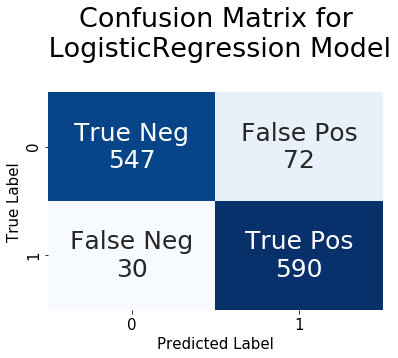

In [45]:
# Plotting our confusion matrix for better view
# credit to the following source on putting group_names and counts together inside heatmap:
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                con_matrix.flatten()]
# Label design - names first, counts below
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

# Reshaping the labels to fit each cell
labels = np.asarray(labels).reshape(2,2)

sns.heatmap((con_matrix), 
            annot=labels,
            annot_kws={"size": 25}, #writing the data value in each cell, big enough to be visible in the presentation
            cmap='Blues', #color of the map (blue)
            fmt="", #format of annotations (no format)
            xticklabels=True, #removing xtickslabels
            yticklabels=True, #removing ytickslabels
            cbar=False); #no colorbar drawing

# Setting the title to size 27
plt.title ('Confusion Matrix for\n LogisticRegression Model\n', 
           size=27);
plt.ylabel('True Label', size=15);
plt.xlabel('Predicted Label', size=15);
plt.yticks(size = 15);
plt.xticks(size = 15);

In [46]:
# Extracting TN, TP, FP, and FN from our confusion matrix
TrueNeg = con_matrix[0][0]
TruePos = con_matrix[1][1]
FalsePos = con_matrix[0][1]
FalseNeg = con_matrix[1][0]

# Our total amount of preditions is the amount of rows in the dataset
Total = preds.shape[0]

# Printing all our classification metrics
print('Accuracy = {:.3f}'.format((TrueNeg+TruePos)/(Total)))
print('Missclassification = {:.3f}'.format(1-(TrueNeg+TruePos)/(Total)))
print('Precision = {:.3f}'.format(TruePos/(FalsePos+TruePos)))
print('Sensitivity = {:.3f}'.format(TruePos/(TruePos+FalseNeg)))
print('Specificity = {:.3f}'.format(TrueNeg/(TrueNeg+FalsePos)))

Accuracy = 0.918
Missclassification = 0.082
Precision = 0.891
Sensitivity = 0.952
Specificity = 0.884


**Observation:**   
Our Logistic Regression Model has strong accuracy score along with strong Sensitivity(0.95), which means that model was able to identify correctly those posts that belong to 'Parenting' subreddit with 95% accuracy.
Specificity(0.88) - our model identifies correctly identify those posts that were written in 'stepratents' subreddit with 88% accuracy.

## ROC AUC Curve

**Receiver Operating Characteristic (ROC) Curve & Area under the ROC curve**  
We are using Receiver Operating Characteristic curve to visualize our trade off between sensitivity and specificity and understand how well-separated our negative and positive populations are. 

In [ ]:
# Calculating probabilities of our best performing model
pred_proba = [i[1] for i in gs1.predict_proba(X_test)]
# Putting probabilities and true values in one dataframe for comparison
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
# Calculation ROC AUC Score
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

**Observation:**  
Our ROC AUC Score of 0.97 (very close to 1), our positive and negative populations are almost perfectly separated and our model is quite good.

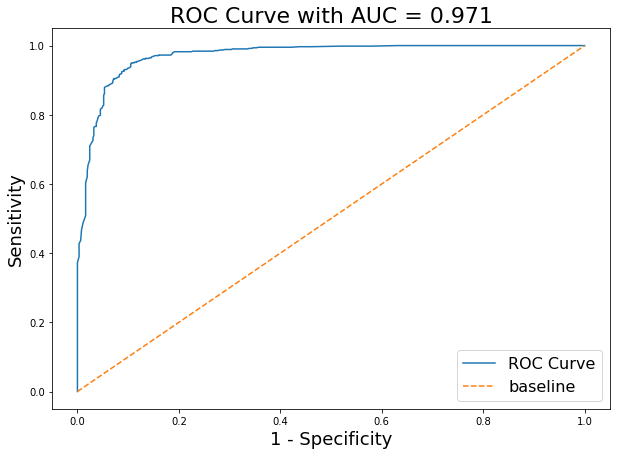

In [48]:
# Visualization of the ROC Curve
plt.figure(figsize = (10,7))
# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')
# Plot baseline
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')
# Label axes
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)
# Create legend
plt.legend(fontsize=16);

## Coefficients

By calculating model coefficients we can see what 1-gram or 2-gram words strongly effect models decision on identifying the subreddit for a post.

In [49]:
# Credit to this source
# source - https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn
# Classifier = gs1.best_estimator_.named_steps['lr']

# Getting names(features) of our coefficients from TfidfVectorizer
names = gs1.best_estimator_.steps[0][1].get_feature_names()
# Getting coefficients from LogisticRegression
coefs = gs1.best_estimator_.steps[1][1].coef_

# Putting these list of strings (names and coefs) into one dataframe
coef_df = pd.DataFrame({
    'word':names,
    'coef':coefs[0],
    'exp_coef':np.exp(coefs[0])
})

# Sorting our coefficients by descending order 
coef_df = coef_df.sort_values('coef', ascending = False)

In [50]:
# Separating coefficients into two group, above 0 and below 0. 
positive_coefs = coef_df[coef_df['coef']>0]
negative_coefs = coef_df[coef_df['coef']<0]

# Getting absolute frequency count of all negative coefficients, for the plot to be 
# more comprehendible 
negative_coefs['abs_coef'] = negative_coefs['coef'].abs()
negative_coefs = negative_coefs.sort_values('abs_coef', ascending =False)

/Users/juliev/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


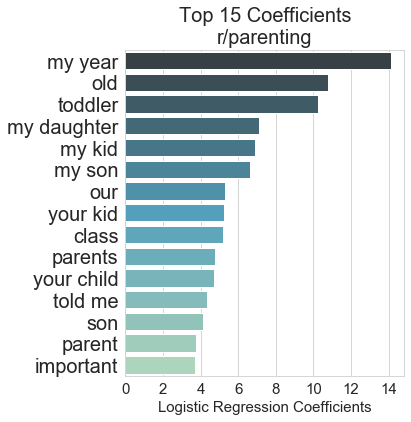

In [51]:
# Visualizing top coefficients of the Linear Regression Model, 
# to pick those that are most effective in predicting
# the correct subreddit
plt.figure(figsize=(5,6))
sns.set_style("whitegrid")

sns.barplot(data=positive_coefs.head(15), 
            x='coef', 
            y='word', 
            palette="GnBu_d") ;

# Setting sise of the title to 20
plt.title ('Top 15 Coefficients\nr/parenting', 
           size=20);

# Removing the xlabel and ylabel
plt.ylabel('');
plt.xlabel('Logistic Regression Coefficients', size = 15);
plt.yticks(size = 20);
plt.xticks(size = 15);

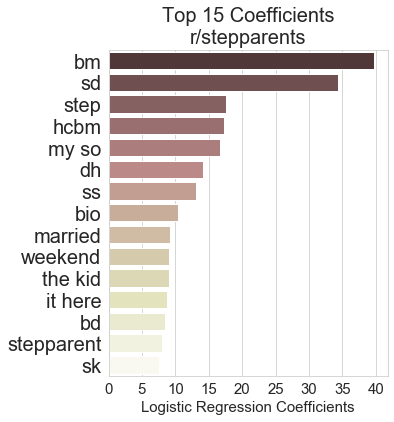

In [52]:
# Visualizing top coefficients of the Linear Regression Model, 
# to pick those that are most effective in predicting
# the correct subreddit
plt.figure(figsize=(5,6))
sns.set_style("whitegrid")

sns.barplot(data=negative_coefs.head(15), 
            x='abs_coef', 
            y='word', 
            palette="pink") ;

# Setting size of the title to 20
plt.title ('Top 15 Coefficients\nr/stepparents', 
           size=20);

# Removing the xlabel and ylabel
plt.ylabel('');
plt.xlabel('Logistic Regression Coefficients', size = 15);
plt.yticks(size = 20);
plt.xticks(size = 15);

### Coefficients interpretation:  
Since we have only collected a sample, about 5,000 posts for both subreddits the coefficients interpretations are used for generalization of the population (all posts ever published in reddit.com)  

**Positive coefficients:**  
As the frequency count for 'my year' increases by 1, the log-odds of a post being from  'r/parenting' increases by 14.136.  
As the frequency count for 'my year' increases by 1, a post is $1.378*10^6$ times as likely to be from 'r/parenting'.

**Negative coefficients:** 
As the frequency count for 'bm' increases by 1, the log-odds of a post being from  'r/parenting' decreases by 39.79.  
As the frequency count for 'bm' increases by 1, a post is $5.2*10^-18$ times as likely to be from 'r/parenting'.

## Conclusion and Recommendations
Using Push shift's API we have successfully collected data from two of the subreddits r/Parenting and r/stepparents. After doing the initial cleanup we have concatenated both title and body of the text in one column, so we can use all rows including those with empty posts. Using lemmatization and both vectorizers (Count and Tfidf) were able to run our data through both Logistic Regression and Multinomial Naive Bayes. 
Scores of our model are as following: 

| Vectorizer     | Classifier | Train Score | Test Score |
|------------|------------|-------------|------------|
|            | Base Line  | 0.50        |     0.50       |
| CountVectorizer | LogisticRegression| 0.94        | 0.89       |
| **TfidfVectorizer**   | **LogisticRegression**| **0.94**        | **0.92**       |
| CountVectorizer      | MultinomialNB| 0.90       | 0.90       |
| TfidfVectorizer      | GaussianNB| 0.89      | 0.88      |

All the models we have trained outperformed the Base Line model. TFIDF vector with Logistic Regression had the best Train and Test score. The scores were 0.94 and 0.92 on the Train and Test respectfully.

Eventhough our Logistic Regression model trained on TfidfVectorizer performed slightly better than other models we still think there is a scope of improvement in the accuracy of the models. The present model is also slightly overfit.  

We noticed that our model has limitations. It seems that most users in each subreddit are using the reddit.com as a tool to express their concerns or worries for the most part, therefore most of the posts are with negative incline. This way model works mostly for posts where users voice their daily problems or questions that they want to express to other subreddit members. 



## Next Steps
As a next step, additional words should be included into our stop-word-list to enable computing **3 or 4-gram words to visualize in depth language patterns**. By doing this, we can optimize our classification matrix: minimizing False Positive and False Negative, and maximize accuracy score.  
We may also consider collecting more data from reddit.com for all the posts written **1-2 years prior to our current collection sample**. 6 months could limit to our model from some other aspects of parents life that could occur during other half of the year.  
We plan to use other sources for additional data: facebook, twitter that might have more subjects discussed between parents and step-parents.  
Also, **different cultures have different angles of parents lives**, therefore collecting more data from different languages is appropriate. 
Implementing additional models like **Decision Trees and Random Forests** for potential optimization of classification matrix.

## References
www.reddit.com